<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
(train_images, _), (_, _) = tf.keras. datasets.fashion_mnist.load_data()
train_images.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [3]:
train_images = train_images.reshape(train_images.shape [0], 28, 28, 1).astype('float32')

train_images.shape

(60000, 28, 28, 1)

In [ ]:
train_images[53111]

In [5]:
train_images = (train_images-127.5)/ 127.5

In [ ]:
train_images[231]

In [7]:
buffer_size = 60000

Batch_size = 32

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(Batch_size)

In [14]:
def generator_model ():
    model = tf.keras.Sequential ()
    model.add(layers. Dense (64, input_dim = 100))
    model.add(layers.ReLU ( ))
    model.add(layers.Dense (128))
    model.add(layers.ReLU())
    model.add(layers.Dense(256))
    model.add(layers. ReLU ( ) )
    model.add(layers. Dense (784, activation = 'relu'))
    model. add (layers. Reshape ( (28, 28, 1)))
    return model

In [15]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               2

In [20]:
noise = tf.random.normal([1,100])
generated_image = generator (noise, training = False)


generated_image.shape

TensorShape([1, 28, 28, 1])

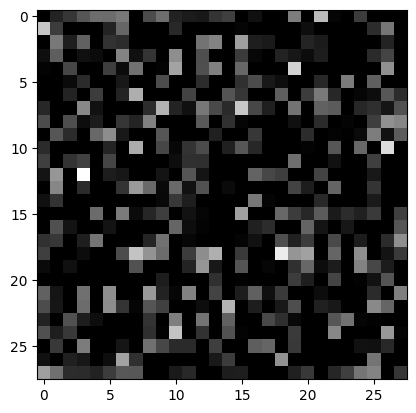

In [21]:
plt.imshow(generated_image[0,:, :, 0], cmap = 'gray')

In [22]:
def discriminator_model ():
    model = tf.keras. Sequential ()
    model. add (layers. Input (shape = (28, 28, 1)))
    model.add(layers.Flatten ( ))
    model. add (layers. Dense (256))
    model. add (layers. LeakyReLU(0.2))
    model.add(layers. Dropout (0.5) )
    model.add (layers. Dense (128))
    model. add (layers. LeakyReLU(0.2))
    model.add (layers. Dropout (0.3) )
    model. add (layers. Dense (64) )
    model. add (layers. LeakyReLU(0.2))
    model.add (layers. Dropout (0.2) )
    model. add (layers. Dense (1, activation ='sigmoid'))
    return model

In [23]:
discriminator = discriminator_model ()

discriminator.summary ( )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [27]:
discriminator = discriminator_model ()
output = discriminator (generated_image)
print (output)

tf.Tensor([[0.5086524]], shape=(1, 1), dtype=float32)


In [28]:
be = tf.keras. losses. BinaryCrossentropy ( )

In [29]:
be

In [30]:
def descriminator_loss(real,fake):
    real_loss = be(tf.ones_like(real),real)
    fake_loss = be(tf.zeros_like(fake),fake)
    total_loss = real_loss + fake_loss

    return total_loss

In [31]:
def generator_loss(fake):
    gen_loss = be(tf.ones_like(fake),fake)
    return gen_loss

In [36]:
tensor = tf.constant([[1, .2, 3], [.4, 5, .6]])
print(tf.zeros_like(tensor))

tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]], shape=(2, 3), dtype=float32)


In [37]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path. join(checkpoint_dir, "ckpt")
checkpoint = tf. train.Checkpoint (generator_optimizer = generator_optimizer,
                                    discriminator_optimizer = discriminator_optimizer,
                                    generator = generator,
                                    discriminator = discriminator)

In [39]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf. random. normal ( [num_examples_to_generate, noise_dim])

In [48]:
@tf.function
def train_step(images):
    noise = tf.random.normal([Batch_size,noise_dim])
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_image = generator(noise,training=True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_image, training = True)

        disc_loss = descriminator_loss (real_output, fake_output)
        gen_loss = generator_loss (fake_output )

    gradients_of_generator = gen_tape.gradient (gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient (disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables) )
    discriminator_optimizer.apply_gradients (zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf. reduce_mean (real_output), tf. reduce_mean (fake_output))

In [49]:
def generate_and_plot_images (model, epoch, test_input):

    predictions = model (test_input, training = False)
    fig = plt.figure(figsize = (8, 4))
    for i in range (predictions.shape [0]):
        plt.subplot (4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array (pred)
        plt. imshow (pred.astype (np.uint8), cmap = 'gray')
        plt.axis ('off')
    plt.savefig('image_at_epoch_{:04d)-png'.format(epoch))
    plt.show ( )